# II on RandomForest

In [3]:
pip install scikit-optimize

  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
     |████████████████████████████████| 197 kB 1.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from pyampute.ampute import MultivariateAmputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import matplotlib.pyplot as plt

import skopt
from skopt.learning import RandomForestRegressor 

In [2]:
def data_gener_X(n, mu, ro):
    #continious data
    Sigma = np.array([[1, ro, ro], [ro, 1, ro], [ro, ro, 1]])
    X_cont = np.random.multivariate_normal(mu, Sigma, size = n)

    return X_cont

In [3]:
mu_X_1 = np.array([5, 5, 10])
mu_X_2 = np.array([1, 100, 10000])

In [4]:
from sklearn.preprocessing import StandardScaler

In [9]:
RFR = RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
#         max_samples=0.5,
        n_jobs=2,
        criterion='mse',
        random_state=0,
    )

def ice_imp(mu, param, num, propor, mech):

    corrs = np.arange(0.1, 1, 0.1)

    df_bias = pd.DataFrame(columns = ['full', mech+str(1), mech+str(2), mech+str(3), mech+str(4)])

    for cor in corrs:

        n = 0
        df_means = pd.DataFrame(columns = ['mean_full', 'mean_M1', 'mean_M2', 'mean_M3', 'mean_M4'])

        for n in np.arange(25):

#             X_full = data_gener_X(1000, mu, cor)
#             df_means.loc[n, 'mean_full'] = X_full[:,num].mean() 

            a = data_gener_X(500, mu, cor)
            aa = pd.DataFrame(a, columns = ['Y1','Y2','X1'])
            X_full = StandardScaler().fit_transform(aa)
            df_means.loc[n, 'mean_full'] = X_full[:,num].mean() 


            #___MAR1________'incomplete_vars': [0,1], 'weights': [0,0,1]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [0,1], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)
            
            imp = IterativeImputer(max_iter = 50, random_state = n, estimator = RFR, sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M1'] = imp[:,num].mean()


            
            #___MAR2________'incomplete_vars': [0], 'weights': [0,1,1]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [0], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)

            imp = IterativeImputer(max_iter = 50, random_state = n, estimator = RFR, sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M2'] = imp[:,num].mean()




            #___MAR3________'incomplete_vars': [1,2], 'weights': [1,0,0]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [1,2], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)

            imp = IterativeImputer(max_iter = 50, random_state = n, estimator = RFR, sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M3'] = imp[:,num].mean()



            
            #___MAR4________'incomplete_vars': [2], 'weights': [1,1,0]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [2], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)

            imp = IterativeImputer(max_iter = 50, random_state = n, estimator = RFR, sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M4'] = imp[:,num].mean()


        df_bias.loc[cor, 'full'] = df_means['mean_full'].mean() - df_means['mean_full'].mean() 
        df_bias.loc[cor, mech+str(1)] = df_means['mean_M1'].mean() - df_means['mean_full'].mean()
        df_bias.loc[cor, mech+str(2)] = df_means['mean_M2'].mean() - df_means['mean_full'].mean()
        df_bias.loc[cor, mech+str(3)] = df_means['mean_M3'].mean() - df_means['mean_full'].mean()
        df_bias.loc[cor, mech+str(4)] = df_means['mean_M4'].mean() - df_means['mean_full'].mean()

    return df_bias

## mu1 = [5, 5, 10]

In [11]:
%%time
mu = mu_X_1

mu1_ice_MAR_Y1_50_1000_scaled = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu1_ice_MAR_Y2_50_1000_scaled = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu1_ice_MAR_X1_50_1000_scaled = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu1_ice_MNAR_Y1_50_1000_scaled = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu1_ice_MNAR_Y2_50_1000_scaled = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu1_ice_MNAR_X1_50_1000_scaled = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx

CPU times: user 16min 34s, sys: 2min 53s, total: 19min 27s
Wall time: 17min 40s


<AxesSubplot:title={'center':'by X1, MNAR'}>

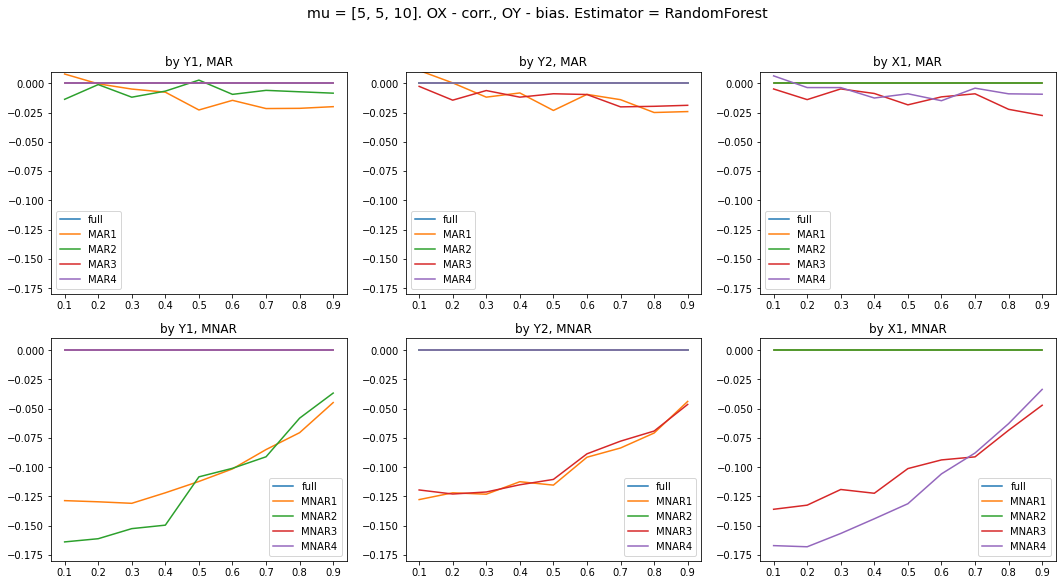

In [12]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = RandomForest", fontsize="x-large")

mu1_ice_MAR_Y1_50_300_scaled.plot(ax = axes[0,0], title = "by Y1, MAR")
mu1_ice_MNAR_Y1_50_300_scaled.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu1_ice_MAR_Y2_50_300_scaled.plot(ax = axes[0,1], title = "by Y2, MAR")
mu1_ice_MNAR_Y2_50_300_scaled.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu1_ice_MAR_X1_50_300_scaled.plot(ax = axes[0,2], title = "by X1, MAR")
mu1_ice_MNAR_X1_50_300_scaled.plot(ax = axes[1,2], title = "by X1, MNAR")

matr(1000), n in 1..100: (calculated 37 mins)

In [6]:
%%time
mu = mu_X_1

mu1_ice_MAR_Y1 = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu1_ice_MAR_Y2 = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu1_ice_MAR_X1 = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu1_ice_MNAR_Y1 = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu1_ice_MNAR_Y2 = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu1_ice_MNAR_X1 = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx

CPU times: user 39min 58s, sys: 4min 43s, total: 44min 42s
Wall time: 37min 52s


/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<AxesSubplot:title={'center':'by X1, MNAR'}>

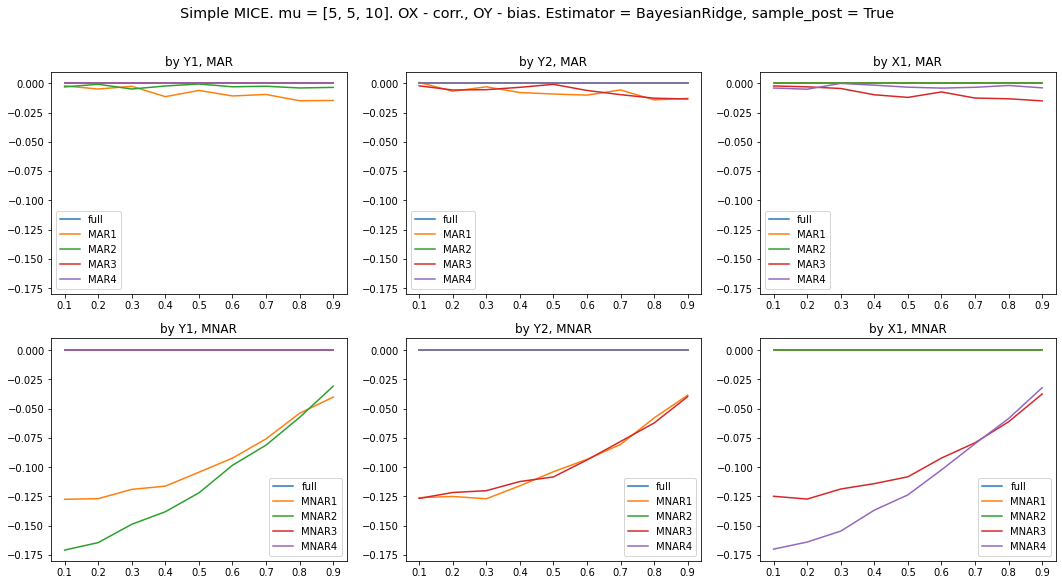

In [7]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = RandomForest", fontsize="x-large")

mu1_ice_MAR_Y1.plot(ax = axes[0,0], title = "by Y1, MAR")
mu1_ice_MNAR_Y1.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu1_ice_MAR_Y2.plot(ax = axes[0,1], title = "by Y2, MAR")
mu1_ice_MNAR_Y2.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu1_ice_MAR_X1.plot(ax = axes[0,2], title = "by X1, MAR")
mu1_ice_MNAR_X1.plot(ax = axes[1,2], title = "by X1, MNAR")

In [6]:
%%time
mu = mu_X_1

mu1_ice_MAR_Y1 = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu1_ice_MAR_Y2 = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu1_ice_MAR_X1 = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu1_ice_MNAR_Y1 = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu1_ice_MNAR_Y2 = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu1_ice_MNAR_X1 = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx

CPU times: user 39min 30s, sys: 4min 25s, total: 43min 55s
Wall time: 37min 17s


/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<AxesSubplot:title={'center':'by X1, MNAR'}>

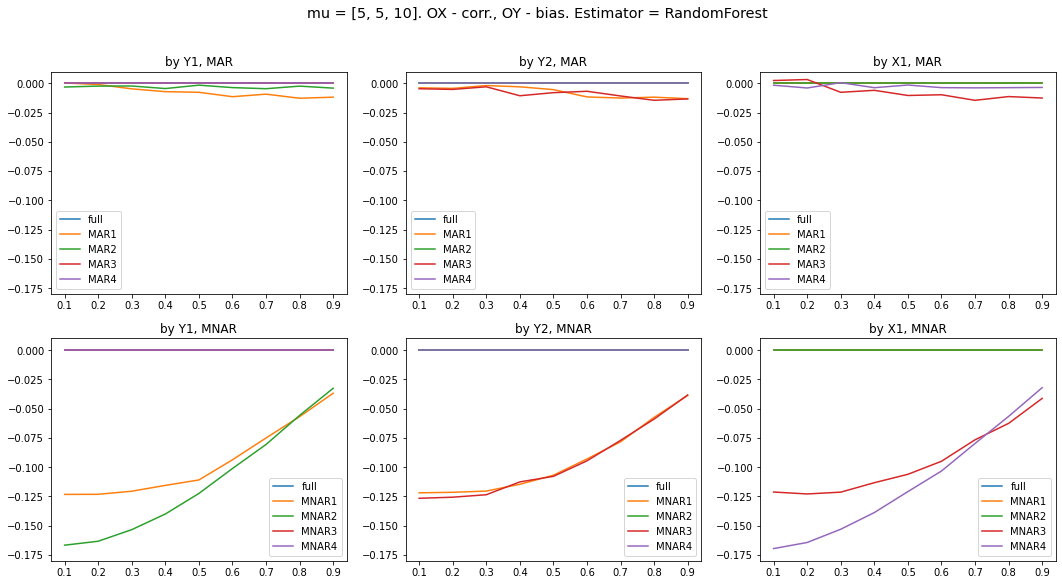

In [7]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = RandomForest", fontsize="x-large")

mu1_ice_MAR_Y1.plot(ax = axes[0,0], title = "by Y1, MAR")
mu1_ice_MNAR_Y1.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu1_ice_MAR_Y2.plot(ax = axes[0,1], title = "by Y2, MAR")
mu1_ice_MNAR_Y2.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu1_ice_MAR_X1.plot(ax = axes[0,2], title = "by X1, MAR")
mu1_ice_MNAR_X1.plot(ax = axes[1,2], title = "by X1, MNAR")

## mu2 = [1, 100, 10000]

In [14]:
%%time
mu = mu_X_2

mu2_ice_MAR_Y1_50_1000_scaled = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu2_ice_MAR_Y2_50_1000_scaled = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu2_ice_MAR_X1_50_1000_scaled = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu2_ice_MNAR_Y1_50_1000_scaled = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu2_ice_MNAR_Y2_50_1000_scaled = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu2_ice_MNAR_X1_50_1000_scaled = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx

CPU times: user 21min 1s, sys: 2min 46s, total: 23min 47s
Wall time: 20min 11s


/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = RandomForest", fontsize="x-large")

mu2_ice_MAR_Y1_50_1000_scaled.plot(ax = axes[0,0], title = "by Y1, MAR")
mu2_ice_MNAR_Y1_50_1000_scaled.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu2_ice_MAR_Y2_50_1000_scaled.plot(ax = axes[0,1], title = "by Y2, MAR")
mu2_ice_MNAR_Y2_50_1000_scaled.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu2_ice_MAR_X1_50_1000_scaled.plot(ax = axes[0,2], title = "by X1, MAR")
mu2_ice_MNAR_X1_50_1000_scaled.plot(ax = axes[1,2], title = "by X1, MNAR")

prop = 0.4

In [11]:
%%time
mu = mu_X_2

mu22_ice_MAR_Y1_25_500_scaled = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.4, mech = "MAR")
mu22_ice_MAR_Y2_25_500_scaled = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.4, mech = "MAR")
mu22_ice_MAR_X1_25_500_scaled = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.4, mech = "MAR")
mu22_ice_MNAR_Y1_25_500_scaled = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.4, mech = "MNAR")
mu22_ice_MNAR_Y2_25_500_scaled = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.4, mech = "MNAR")
mu22_ice_MNAR_X1_25_500_scaled = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.4, mech = "MNAR")

/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/envs/mice/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-10.9-x86_64.egg/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


ValueError: Expected impurity to be 'mse', got squared_error instead

NameError: name 'mu22_ice_MNAR_Y1_50_300_scaled' is not defined

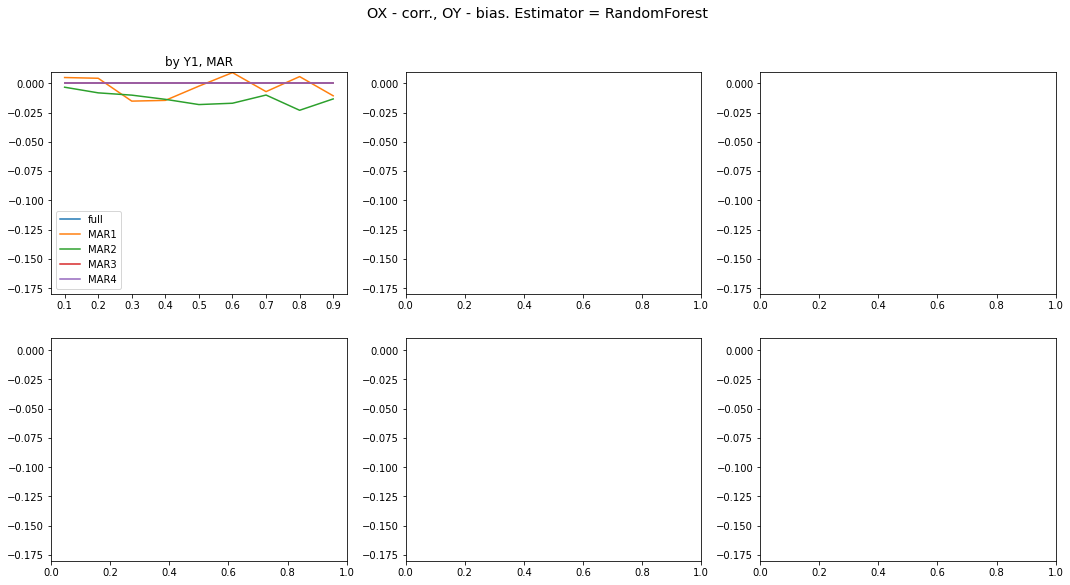

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("OX - corr., OY - bias. Estimator = RandomForest", fontsize="x-large")

mu22_ice_MAR_Y1_25_500_scaled.plot(ax = axes[0,0], title = "by Y1, MAR")
mu22_ice_MNAR_Y1_25_500_scaled.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu22_ice_MAR_Y2_25_500_scaled.plot(ax = axes[0,1], title = "by Y2, MAR")
mu22_ice_MNAR_Y2_25_500_scaled.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu22_ice_MAR_X1_25_500_scaled.plot(ax = axes[0,2], title = "by X1, MAR")
mu22_ice_MNAR_X1_25_500_scaled.plot(ax = axes[1,2], title = "by X1, MNAR")

matr(1000), n in 1..100: (calculated  mins)

In [10]:
%%time
mu = mu_X_2

mu2_ice_MAR_Y1 = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
mu2_ice_MAR_Y2 = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
mu2_ice_MAR_X1 = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu2_ice_MNAR_Y1 = ice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
mu2_ice_MNAR_Y2 = ice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
mu2_ice_MNAR_X1 = ice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

CPU times: user 8min 11s, sys: 40.7 s, total: 8min 52s
Wall time: 7min 48s


<AxesSubplot:title={'center':'by X1, MNAR'}>

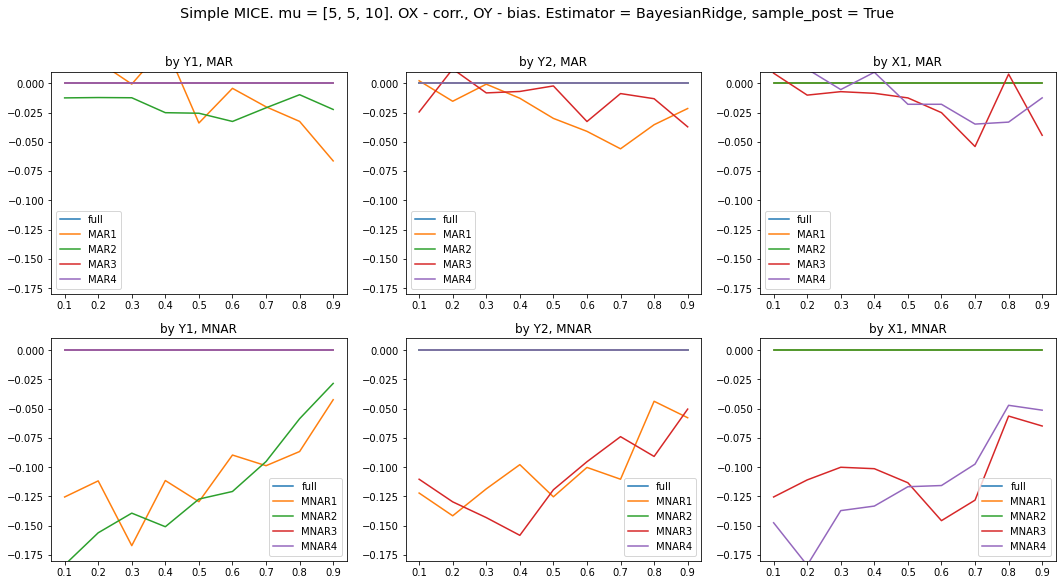

In [24]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("Simple MICE. mu = [5, 5, 10]. OX - corr., OY - bias. Estimator = BayesianRidge, sample_post = True", fontsize="x-large")

mu1_ice_MAR_Y1.plot(ax = axes[0,0], title = "by Y1, MAR")
mu1_ice_MNAR_Y1.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu1_ice_MAR_Y2.plot(ax = axes[0,1], title = "by Y2, MAR")
mu1_ice_MNAR_Y2.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu1_ice_MAR_X1.plot(ax = axes[0,2], title = "by X1, MAR")
mu1_ice_MNAR_X1.plot(ax = axes[1,2], title = "by X1, MNAR")

<AxesSubplot:title={'center':'by X1, MNAR'}>

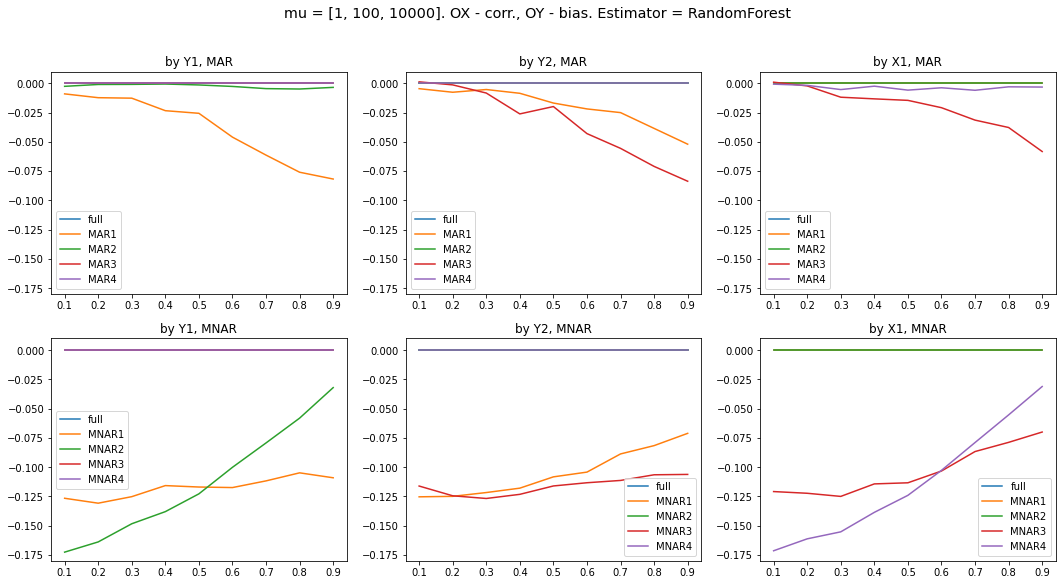

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [1, 100, 10000]. OX - corr., OY - bias. Estimator = RandomForest", fontsize="x-large")

mu2_ice_MAR_Y1.plot(ax = axes[0,0], title = "by Y1, MAR")
mu2_ice_MNAR_Y1.plot(ax = axes[1,0], title = "by Y1, MNAR")
mu2_ice_MAR_Y2.plot(ax = axes[0,1], title = "by Y2, MAR")
mu2_ice_MNAR_Y2.plot(ax = axes[1,1], title = "by Y2, MNAR")
mu2_ice_MAR_X1.plot(ax = axes[0,2], title = "by X1, MAR")
mu2_ice_MNAR_X1.plot(ax = axes[1,2], title = "by X1, MNAR")